# Baseline model

Defining accuracy achieved with minimal effort. In this case, by generating expectated outcomes through a random guess of the race result.

In [1]:
import itertools
import yaml

import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics

In [2]:
# Move project root folder
%cd ..

/Users/mwtmurphy/projects/f1-elo


/Users/mwtmurphy/Library/Caches/pypoetry/virtualenvs/f1-elo-tRE7S7Hg-py3.10/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
with open("params.yaml") as conf_file:
    CONFIG = yaml.safe_load(conf_file)

In [8]:
features_df = pd.read_csv(CONFIG["data"]["features_path"])
features_df["prevRaces"] = features_df.groupby("driverId").cumcount()

In [5]:
c = 400 # scaling factor
k = 24 # maximum possible adjustment per game
w = 1 # team weighting

# Elo rating system

In [15]:
dri_scores = {id: CONFIG["model"]["start_score"] for id in set(features_df["driverId"])}
#con_scores = {id: CONFIG["model"]["start_score"] for id in set(features_df["constructorId"])}
features_df[["q", "expected", "actual"]] = 0.0
features_df[["startDriScore", "startConScore", "startScore", "endDriScore", "endConScore"]] = 0.0
pred_vals, true_vals = [], []

yr_df = features_df[["year", "round"]].drop_duplicates()

for _, (yr, rnd) in yr_df.iterrows():
    valid_ix = (features_df["year"] == yr) & (features_df["round"] == rnd)

    # map start scores per round
    features_df.loc[valid_ix, "startDriScore"] = features_df.loc[valid_ix, "driverId"].map(dri_scores)
    #features_df.loc[valid_ix, "startConScore"] = features_df.loc[valid_ix, "constructorId"].map(con_scores)
    features_df.loc[valid_ix, "startScore"] = features_df.loc[valid_ix, "startDriScore"] #+ w * features_df.loc[valid_ix, "startConScore"]
    features_df.loc[valid_ix, "q"] = 10 ** (features_df.loc[valid_ix, "startScore"] / c)

    # get scores per 1v1
    for ix_1, ix_2 in itertools.combinations(features_df[valid_ix].index, 2):
        row_i = features_df.loc[ix_1,:]
        row_j = features_df.loc[ix_2,:]

        # continue if drivers in same car, else get actual outcomes
        if row_i["mapPosition"] == row_j["mapPosition"]:
            continue
        elif row_i["mapPosition"] < row_j["mapPosition"]:
            a_i = 1
            a_j = 0
        else:
            a_i = 0
            a_j = 1

        # calculate expected outcomes
        e_i = row_i["q"] / (row_i["q"] + row_j["q"])        
        e_j = row_j["q"] / (row_i["q"] + row_j["q"])

        # update expected and actual values
        features_df.loc[ix_1, "expected"] += e_i
        features_df.loc[ix_1, "actual"] += a_i
        features_df.loc[ix_2, "expected"] += e_j
        features_df.loc[ix_2, "actual"] += a_j

        # log individual results for error calc
        pred_vals.append(e_i)
        true_vals.append(a_i)

    # update ratings per round
    for ix, row in features_df[valid_ix].iterrows():
        dri_scores[row["driverId"]] += (k * (row["actual"] - row["expected"]))
        features_df.loc[ix, "endDriverScore"] = dri_scores[row["driverId"]]

err_df = pd.DataFrame({"pred": pred_vals, "true": true_vals})
root_brier_score = np.sqrt(metrics.brier_score_loss(err_df["true"], err_df["pred"]))

print(root_brier_score)

0.49969496572295063


# Investigating error

In [16]:
err_df["elo_diff"] = err_df["elo_a"] - err_df["elo_b"]
err_df["min_races"] = err_df[["pr_a", "pr_b"]].min(axis=1)

KeyError: 'elo_a'

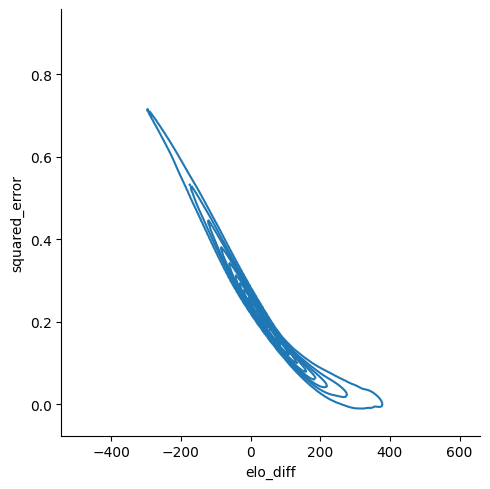

In [13]:
sn.displot(err_df.sample(20000), x="elo_diff", y="squared_error", kind="kde")

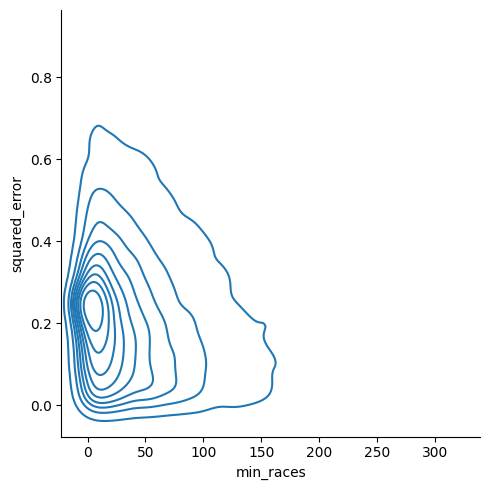

In [14]:
sn.displot(err_df.sample(20000), x="min_races", y="squared_error", kind="kde")